<a href="https://colab.research.google.com/github/pramod-Paratabadi/Google-Colab/blob/master/Twitter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
!pip install GetOldTweets3
import pandas as pd
import numpy as np
import re
from pprint import pprint
from datetime import datetime

#scraping
import GetOldTweets3 as got
import time

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
def get_tweets(text_query, start_date, end_date, lang, location, within):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setLang(lang)\
                          .setNear(location)\
                          .setWithin(within)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    tw_df = pd.DataFrame(text_tweets, 
                         columns = ['User', 'Text', 'Date', 'Retweets', 'Favorites', 'HashTags'])
    
    return tw_df

In [0]:
# set attributes needed for get_tweets
text_query = '#StayHome'
start_date = '2020-04-05'
end_date = '2020-05-12'
lang = 'en'
within = '50mi'

citys = ['India, Pune', 'New York City, New York','Boston, Massachusetts','Chicago, Illinois','Detroit, Michigan','Los Angeles, California','Houston, Texas','Newark, New Jersey','Miami, Florida','Philadelphia, Pennsylvania','New Orleans, Louisiana']

In [102]:

# scrap needed info and export to csv file
for city in citys:
    location = city
    df = get_tweets(text_query, start_date, end_date, lang, location, within)
    df.to_csv(city + '.csv', index = False)
    print(city)
    time.sleep(120)

India, Pune
New York City, New York
Boston, Massachusetts
Chicago, Illinois
Detroit, Michigan
Los Angeles, California
Houston, Texas
Newark, New Jersey
Miami, Florida
Philadelphia, Pennsylvania
New Orleans, Louisiana


In [0]:
# add 'City' column and combine all datasets
city_column = ['IND','NY', 'BOSTON', 'CHI', 'DETROIT', 'LA', 'HOUSTON', 'NEWARK', 'MIA', 'PHIL', 'NEW ORLEANS']
stayhome = pd.DataFrame()
for i in range(len(city_column)):
    df = pd.read_csv(citys[i] + '.csv')
    df['City'] = city_column[i]
    stayhome = pd.concat([stayhome, df], axis = 0)
stayhome.to_csv('StayHome.csv', index = False)


In [0]:
stayhome.to_csv('StayHome.csv', index = False)


In [105]:
df = pd.read_csv("StayHome.csv")
df.shape

(15210, 7)

In [0]:
# remove duplicates
df.replace('[]', np.nan,inplace=True)
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)

# devide timestamp into date and time
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].apply( lambda x: x.strftime("%Y-%m-%d"))
df['time'] = df['Date'].apply( lambda x: x.strftime("%H-%M-%S"))
df.drop(['Date'],axis = 1, inplace =True)

# replace city initials with city names
replace_values = {'NY' : 'New York', 'BOSTON' : 'Boston', 'CHI' : 'Chicago', 'DETROIT' : 'Detroit', 'HOUSTON' : 'Houston',
                  'LA' : 'Los Angeles', 'MIA' : 'Miami', 'NEWARK' : 'Newark', 'NEW ORLEANS' : 'New Orleans', 'PHIL' : 'Philadelphia'}                                                                                          
df = df.replace({"City": replace_values})

In [110]:
# count number of unique users for different time period
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates: 
    unique_user.append(df[df['date'] < date]['User'].nunique())

lag_user = [0]+unique_user 
lag_user = lag_user[:-1]

# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis = 1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-02,167,191,1.143713,5103,97
2020-05-03,165,189,1.145455,5186,83
2020-05-04,142,155,1.091549,5263,77
2020-05-05,175,198,1.131429,5322,59
2020-05-06,147,160,1.088435,5390,68
2020-05-07,130,143,1.100000,5452,62
2020-05-08,128,147,1.148438,5503,51
2020-05-09,116,137,1.181034,5549,46
2020-05-10,104,113,1.086538,5588,39


In [111]:
# select '2020-04-06' as division
# old users: who started to be active before 04-06
# new_users: who weren't active until 04-06
existing_user= df[df['date'] < '2020-04-06']['User'].unique()

# retain all old users
df1 = df[df['User'].isin(existing_user)]                      
df2 = df[-df['User'].isin(existing_user)]

# sample new users
df2 = df2.sample(1300)

# get new sample
df = pd.concat([df1,df2])                                     

# export new sample
df.to_csv("StayHome_final.csv", index = False)
df.shape

(3057, 8)

[Text(0, 0, '2020-04-05'),
 Text(0, 0, '2020-04-06'),
 Text(0, 0, '2020-04-07'),
 Text(0, 0, '2020-04-08'),
 Text(0, 0, '2020-04-09'),
 Text(0, 0, '2020-04-10'),
 Text(0, 0, '2020-04-11'),
 Text(0, 0, '2020-04-12'),
 Text(0, 0, '2020-04-13'),
 Text(0, 0, '2020-04-14'),
 Text(0, 0, '2020-04-15'),
 Text(0, 0, '2020-04-16'),
 Text(0, 0, '2020-04-17'),
 Text(0, 0, '2020-04-18'),
 Text(0, 0, '2020-04-19'),
 Text(0, 0, '2020-04-20'),
 Text(0, 0, '2020-04-21'),
 Text(0, 0, '2020-04-22'),
 Text(0, 0, '2020-04-23'),
 Text(0, 0, '2020-04-24'),
 Text(0, 0, '2020-04-25'),
 Text(0, 0, '2020-04-26'),
 Text(0, 0, '2020-04-27'),
 Text(0, 0, '2020-04-28'),
 Text(0, 0, '2020-04-29'),
 Text(0, 0, '2020-04-30'),
 Text(0, 0, '2020-05-01'),
 Text(0, 0, '2020-05-02'),
 Text(0, 0, '2020-05-03'),
 Text(0, 0, '2020-05-04'),
 Text(0, 0, '2020-05-05'),
 Text(0, 0, '2020-05-06'),
 Text(0, 0, '2020-05-07'),
 Text(0, 0, '2020-05-08'),
 Text(0, 0, '2020-05-09'),
 Text(0, 0, '2020-05-10'),
 Text(0, 0, '2020-05-11')]

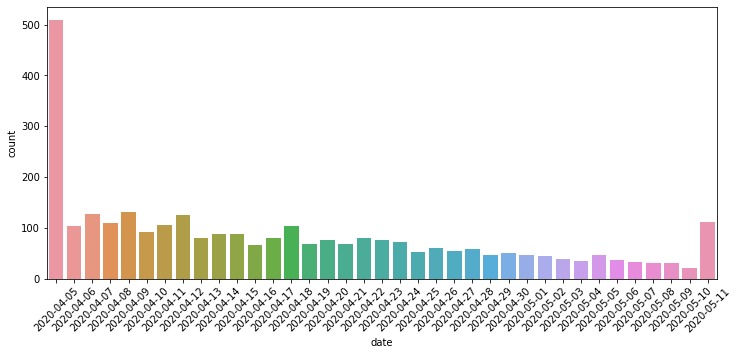

In [112]:
# plot the distribution of our new sample
fig = plt.figure(figsize = (12,5))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

In [113]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis =1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-02,40,44,1.100000,5103,97
2020-05-03,37,39,1.054054,5186,83
2020-05-04,31,35,1.129032,5263,77
2020-05-05,43,47,1.093023,5322,59
2020-05-06,35,37,1.057143,5390,68
2020-05-07,29,34,1.172414,5452,62
2020-05-08,27,32,1.185185,5503,51
2020-05-09,28,32,1.142857,5549,46
2020-05-10,22,22,1.000000,5588,39


In [114]:
! jupyter kernelspec list


Available kernels:
  ir         /usr/local/share/jupyter/kernels/ir
  python2    /usr/local/share/jupyter/kernels/python2
  python3    /usr/local/share/jupyter/kernels/python3
  swift      /usr/local/share/jupyter/kernels/swift


In [115]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#word count
from collections import Counter

#word clouds
import heapq
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import collections
import matplotlib.cm as cm
from matplotlib import rcParams
from tqdm import tqdm

#sentiment analysis
from textblob import TextBlob

#text preprocessing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

#hide warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [116]:
# Topic modeling
# spacy for lemmatization
import spacy;
import en_core_web_sm
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
!pip install pyLDAvis
# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [0]:
# read file
df = pd.read_csv("StayHome_final.csv")

In [0]:
# drop duplicate rows
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)

In [119]:
df.head()


,User,Text,Retweets,Favorites,HashTags,City,date,time
0,aksrock,"May the 4th , just #StayHome",0,0,#StayHome #StayHome,IND,2020-05-04,18-46-40
1,puneet6565,I live tea #comedyvideos #blueridge #videoofth...,1,0,#comedyvideos #blueridge #videooftheday #video...,IND,2020-05-03,18-17-28
2,puneet6565,Duet act with stylewithrouge #styleblogger #gr...,1,0,#styleblogger #greendelhiblogger #greensuperMo...,IND,2020-05-03,18-09-42
3,puneet6565,It's been a long way #bollywooddialogue #bolly...,0,0,#bollywooddialogue #bollywooddialogues #mumbai...,IND,2020-05-01,15-20-49
4,Deejay_Lemon,Don’t forget to get morning sunlight for 10 mi...,0,1,#stayhome #stayhome #staysafe #weshallovercome...,IND,2020-04-30,03-43-48


In [120]:
print('shape:', df.shape)
print('number of tweets:', df['Text'].nunique())
print('number of users:', df['User'].nunique())

print("range:", df['date'].min(),",", df['date'].max())
print("dates:",df['date'].nunique())

shape: (3057, 8)
number of tweets: 3057
number of users: 1558
range: 2020-04-05 , 2020-05-11
dates: 37


In [121]:
# get information about the number of missing values and their percentage
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(df)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
HashTags,16,0.5


Text(0.5, 1.0, 'Number of Tweets per day')

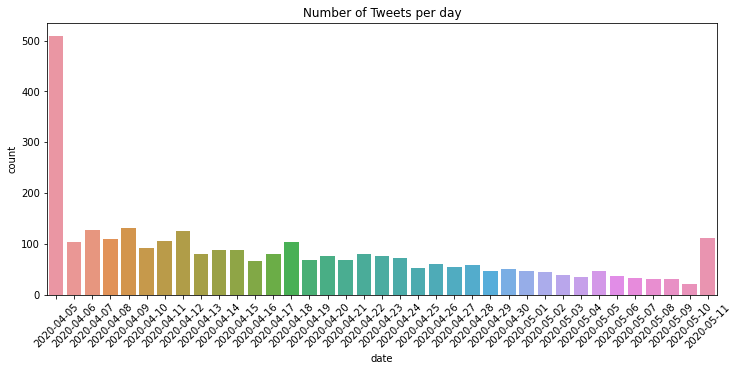

In [122]:

# plot number of tweets everyday
fig = plt.figure(figsize = (12,5))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Number of Tweets per day')

Text(0.5, 1.0, 'Number of Users per day')

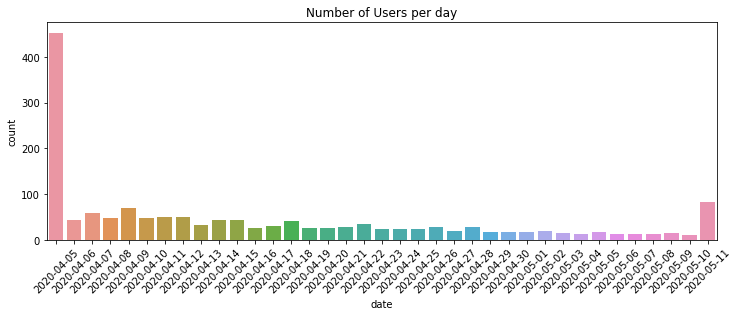

In [123]:
dates = sorted(df['date'].unique())
fig= plt.figure(figsize=(12,4))
chart = sns.countplot(df.groupby(['User'])['date'].min(), order = dates)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Number of Users per day')

Text(0.5, 1.0, 'Number of Tweets in Different Cities Groups across Dates')

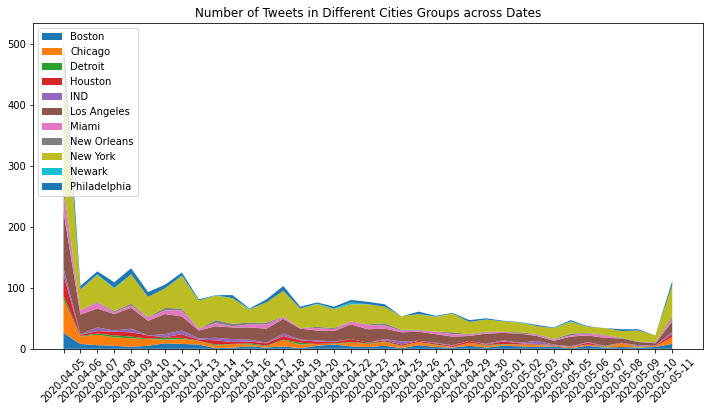

In [124]:
# plot number of tweets everyday in each city 
pivot = pd.pivot_table(df, index=['City'],
                         columns=['date'],
                         values=['Text'], 
                         aggfunc = lambda x: len(x), 
                         fill_value=0)

fig= plt.figure(figsize = (12,6))
plt.stackplot(sorted(df['date'].unique()), pivot.values, labels = pivot.index)
ax = plt.gca()
ax.set_xticks(sorted(df['date'].unique()))
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.title('Number of Tweets in Different Cities Groups across Dates')

In [0]:

# extract data that doesn't contain NAs only
df = df[df['HashTags'].notna()]

In [0]:
# since there's not a lot of twitter before 2020-03-13, we only need data after 2020-03-13
df = df[df['date']>'2020-03-13']

In [0]:

# get rid of all kinds of strange symbols from text
def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    return Text

# remove urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row =  url_pattern.sub(r'', row)
    return row

# remove @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags, com frin text
def removes(row):
    url_pattern = re.compile(r"(\w+:\/\/\S+)|(#(\w+))|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row

In [0]:
# apply all the preprocess functions
df['text_nlp'] = preprocess(df.Text)
df['text_nlp'] = df['text_nlp'].apply(remove_urls)
df['text_nlp'] = df['text_nlp'].apply(removes)

In [129]:
# text before preprocessing
df.Text[5]

'Some people should know that doing any shit is not to be consider as an act of romance. #StayHome'

In [130]:

# text after preprocessing
df.text_nlp[5]

'Some people should know that doing any shit is not to be consider as an act of romance. '

In [0]:
# Get the lenghth of text and word count
df['text_len'] = df.text_nlp.astype(str).apply(len)
df['word_count'] = df.text_nlp.apply(lambda x: len(str(x).split()))

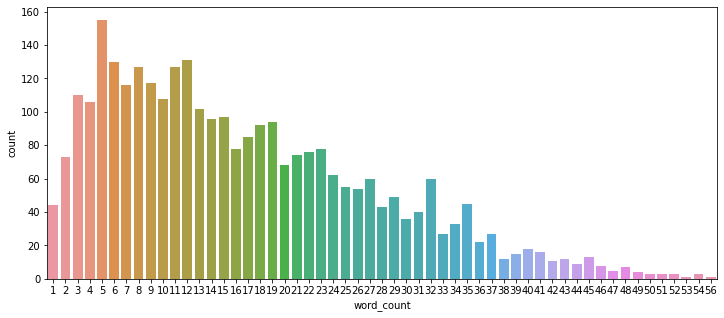

In [132]:

fig= plt.figure(figsize = (12,5))
sns.countplot(df['word_count'])

In [0]:
# Handling Abbreviation
def decontracted(phrase):
    phrase = re.sub(r"that\'s", "that is", phrase)   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# decontracte words
df.text_nlp = df.text_nlp.apply(lambda x: decontracted(x).lower())

In [0]:
# remove stop words
stop_words = stopwords.words('english')
not_stopwords = {}
common_words =['com','twitter','please',
               'the','would','could','can','may','must', 
              # 'us','i','you','this','we','me','that','it',
               'de','s','pic','t','m','en','la','que','don','re','e','el','ca']
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
df.text_nlp = df.text_nlp.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))

In [0]:

# remove whitespace and punctuations
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
df.text_nlp = df.text_nlp.apply(lambda x: rm_punc.sub(' ', x))
df.text_nlp = df.text_nlp.apply(lambda x: rm_space.sub(' ', x))

In [136]:
df.text_nlp[5]


'people know shit consider act romance '

## Sentiment Analysis¶


In [137]:

# get the polarity of each text
df['polarity'] = df.text_nlp.map(lambda text: TextBlob(text).sentiment.polarity)

# classify sentiment into positive and negative ones
df['sentiment'] = ''
df['sentiment'][df['polarity'] > 0] = 'positive'
df['sentiment'][df['polarity'] == 0] = 'neutral'
df['sentiment'][df['polarity'] < 0] = 'negative'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 1000.0)

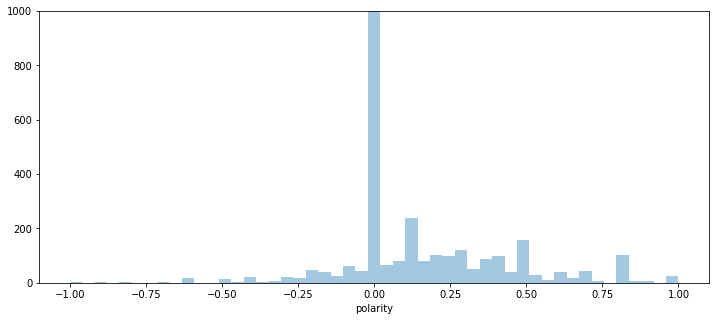

In [138]:
fig = plt.figure(figsize=(12,5))
sns.distplot(df['polarity'],kde = False)
plt.ylim(0, 1000)

In [140]:

# Sentiment 
df.groupby('sentiment').Text.count()

sentiment
negative     347
neutral     1143
positive    1551
Name: Text, dtype: int64

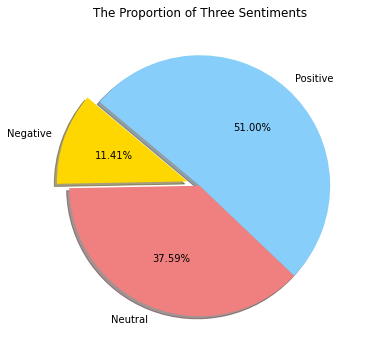

In [141]:
# draw a pie chart to show the ratio of 'Negative', 'Neutral' and 'Positive' tweets
fig = plt.figure(figsize=(6,6))
labels = 'Negative', 'Neutral', 'Positive'
sizes = df.groupby('sentiment').Text.count().values
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('The Proportion of Three Sentiments')
plt.show()

Text(0.5, 1.0, 'Average sentiment of Tweets across Dates')

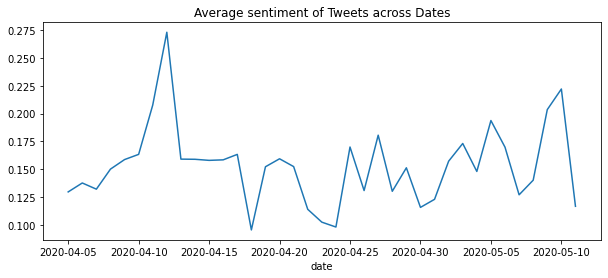

In [142]:
# plot sentiment fluctuation with date
fig, ax1 = plt.subplots(figsize=(10,4))
df.groupby(['date']).mean()['polarity'].plot(kind = 'line')
plt.title('Average sentiment of Tweets across Dates')

In [143]:
# Create word frequency count
num_words = 300
word2count = {}
for i in tqdm(range(len(df['text_nlp']))): 
    for word in df['text_nlp'].iloc[i].split():
        if word not in word2count.keys(): 
            word2count[word] = 1
        else: 
            word2count[word] += 1
            
freq_words = heapq.nlargest(num_words, word2count, key=word2count.get)

100%|██████████| 3041/3041 [00:00<00:00, 47803.31it/s]


In [0]:
from wordcloud import WordCloud, ImageColorGenerator
from os import path, getcwd
from PIL import Image
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
d = getcwd()
mask = np.array(Image.open(path.join(d,'twitter.png')).convert("RGB"))
color = np.array(Image.open(path.join(d,'color.png')).convert("RGB"))

def func(arr):   
    if(arr[2]==0):
        return np.array([255,255,255],dtype="uint8")
    else:
        return arr

mask=np.apply_along_axis(func, 2, mask)
color=np.apply_along_axis(func, 2, color)

In [0]:
red = np.array(Image.open(path.join(d,'red.png')).convert("RGB"))
red=np.apply_along_axis(func, 2, red)

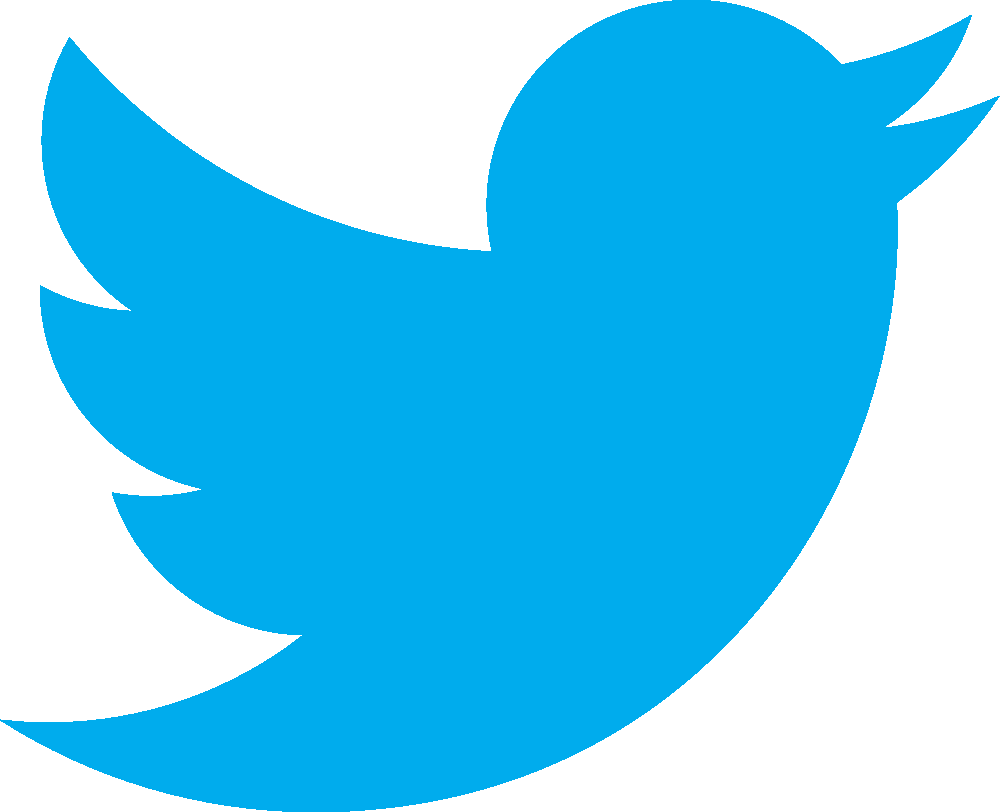

In [155]:
Image.fromarray(mask,"RGB")


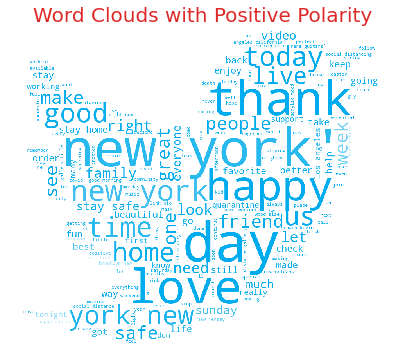

In [156]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(df['text_nlp'][df['sentiment'] == 'positive'])))
    # declare our figure  
image_colors = ImageColorGenerator(color)
plt.figure(figsize=(7,6))
plt.title("Word Clouds with Positive Polarity", fontsize=20,color='#DE2929')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

ValueError: ignored

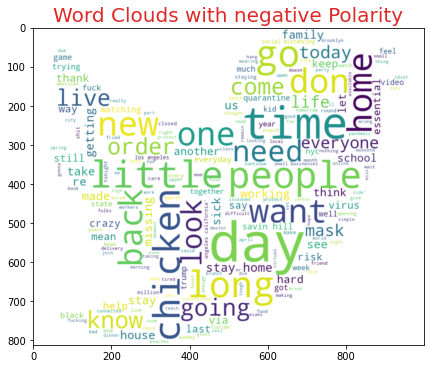

In [157]:
wordcloud = WordCloud(width=480, height=480, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white', stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(df['text_nlp'][df['sentiment'] == 'negative'])))
    # declare our figure  
image_colors = ImageColorGenerator(red)
plt.figure(figsize=(7,6))
plt.title("Word Clouds with negative Polarity", fontsize=20,color='#DE2929')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [158]:
wordcloud.to_file('negative1.png')


## Topic Modeing
preprocessing for Topic Modeling

In [0]:

# tokenize each sentence into a list of words, removing punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text_nlp']))

# Remove Stop and common Words
stopwords = nltk.corpus.stopwords.words('english')
# 'home', 'stay','new','york', 'time',
newStopWords =  ['s','t',  'm', 're','don','ve','2', '3', '1', 
                 'it', 'i', 'us', 'get', 'you', 'let', 'going', 'know', 
                'make', 'take', 'still','got', 'can', 'this', 'all', 'me','go',
                'even', 'here', 'well', 'much', 'many', 'way', 'want', 'every', 'little']
stopwords.extend(newStopWords)

data_words = [[word for word in doc if word not in stopwords] for doc in data_words]

In [0]:
# restrict words to only noun, adjective, verb and adverb
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#### Finding the optimal number of topics using LdaMallet model¶


In [0]:

start=24
limit=32
step=2
random = 155

In [0]:

# Write the function to compute coherence values for each model. 
# This could help us choose how many topics should be included into our model.

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [183]:
# compute coherence values for each model
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



CalledProcessError: ignored

In [174]:

# plot the coherence values when number of topics# plot the coherence values when number of topics equals to different numbers
for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of", round(cv, 4)) 
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: ignored

In [175]:
# plot the coherence values when number of topics equals to different numbers
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: ignored

#### Finding Key Words for each topic using optimal LdaMallet model


In [176]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             num_topics=30, 
                                             id2word=id2word,
                                             random_seed = 155)

TypeError: ignored

In [177]:
# Show Topics
model_topics = ldamallet.show_topics(formatted=False)
pprint(sorted(ldamallet.print_topics(num_words=8)))

NameError: ignored

In [178]:

topics = pd.DataFrame(sorted(ldamallet.print_topics(num_words=10)))
topics.columns = ['Topic_num','Key_words']
topics.to_csv('30_topics_2.csv',index = False)

NameError: ignored

In [179]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

NameError: ignored

In [0]:
topic_names = ['beautiful/smile/pretty/staff',
 'mask/face/wear',
 'time/week/remember/ago',
 'friend/family/grateful/neighbor',
 'worker/care/health/risk',
 'read/weekend/exercise/book',
 'home/stay/calm/connected',
 'social/distancing/save/doctor',
 'love/prayer/hand/wash',
 'case/death/state/test',
 'watch/video/share/youtube',
 'free/place/donate',
 'spread/important/news/high',
 'stay/safe/home/healthy',
 'virus/big/happen/break',
 'work/hard/hospital/patient/bed',
 'kid/virtual/class/school',
 'quarantine/isolation',
 'community/pandemic/protect/reminder',
 'good/feel/world/moment/photo',
 'tonight/tomorrow/night',
 'people/die/sick',
 'word/message/picture',
 'play/happy/music/game',
 'challenge/workout/fresh/air',
 'food/eat/house/clean',
 'amazing/dinner/cook',
 'show/favorite/movie',
 'order/call/online/delivery',
 'close/business/public/park']

## Topic Vector


In [181]:
topics_docs = []
for m in ldamallet[corpus]:
    topics_docs.append(m)

train_vecs = []
for i in topics_docs:
    topic_vec = [j[1] for j in i]
    train_vecs.append(topic_vec) 

topic_dis = pd.DataFrame(train_vecs,columns=topic_names)
topic_dis.head()

df= pd.concat([df,topic_dis],axis = 1)
df.head(2)

NameError: ignored

## Word Vector¶


In [0]:
# Creat all the interested word for analysis
Interesting_words = ['tv','reading','video','game','drinking','puzzle','beach','eating','walking',
                 'tiktok','music','spotify','talk','gym','exercise','phone','zoom',
                'talk','eat','youtube','netflix','watch','episode','workout','challenge',
                 'listen','song','park','beach','reading',
                 'puzzle','sleeping','sleep','instagram','ins','virtual',
                 'lunch','breakfast','dinner','cooking','working',
                 'social','friends','friend','family','kids','delivery','wine']

In [76]:
for col in Interesting_words:
    StayHome[col]=StayHome.text_nlp.apply(lambda x: int(col in str(x)))

NameError: ignored

## City Vector¶


In [77]:

# get all the cities
city = list(StayHome['City'].unique())

NameError: ignored

In [78]:
city.remove(np.nan)


AttributeError: ignored

In [79]:
# create city vector
for col in city:
    StayHome[col]=StayHome.City.apply(lambda x: int(str(x) == col))
StayHome = StayHome.drop('Houston',1)
StayHome = StayHome.dropna()

NameError: ignored

## Sentiment Score¶


In [80]:

# create polarity score and subjectivity score
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

StayHome['Text'] = StayHome['Text'].apply(str)
StayHome['polarity'] = StayHome['Text'].apply(pol)
StayHome['subjectivity'] = StayHome['Text'].apply(sub)

NameError: ignored

## Lasso Regression¶


In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [82]:
# run a lasso regression on all the variables and polarity
X = StayHome.drop(['User', 'Text', 'Retweets', 'Favorites', 'HashTags','date','City',
       'time', 'text_nlp', 'text_len', 'word_count','polarity','subjectivity'], 1)
Y = StayHome['polarity']

NameError: ignored

In [83]:

# train test split
X_test,X_train,y_test,y_train=train_test_split(X,Y, test_size=0.3, random_state=31)
# run lassocv
lasso = LassoCV(cv=10, random_state=0)
lasso.fit(X_train, y_train)
# predict y
Y_pred = lasso.predict(X_test)
# performance
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
print(train_score)
print(test_score)
# create a dictionary with feature and coeficient
coef_dict = dict(zip(list(X.columns),list(list(lasso.coef_))))
# rank feature by coeficient value
import operator
sorted_importance = sorted(coef_dict.items(), key=operator.itemgetter(1))
sorted_importance

NameError: ignored

## Topic Modeling Ananlyais


In [84]:

topic_list = df.columns[13:43]
topic_mean = df.iloc[:,13:43].mean().values

for i in range(len(topic_list)):
    df[i] = np.where(df[topic_list[i]] > 0.08,1,0)
    
topic_polarity = list()
for i in range(30):
    topic_polarity.append(df[df[i]==1]['polarity'].mean())
    
topic_polarity = pd.DataFrame({'Topics':topic_list,'Polarity':topic_polarity})
topic_polarity.sort_values(by = ['Polarity'],ascending=False)

KeyError: ignored

## Single-word analysis¶


In [0]:

# count how much time each topic is discussed in each city
topic_cities = df.groupby(['City']).sum().iloc[:,-30:].transpose()
df = df.dropna(subset = ['text_nlp'])

specail_words = ['video','netflix','watch','episode','movie',
                 'gym','exercise','workout','air','fresh',
                 'listen','music','song',
                 'sleeping',
                 'prayer',
                 'reading','book',
                 'game',
                 'instagram',
                 'phone','zoom','virtual','message',
                 'eat','lunch','breakfast','dinner','cooking',
                 'friends','friend','family','neighbor',
                 'delivery',
                 'drinking','wine']
avg_polarity = list()
num_texts = list()
for word in specail_words:
    avg_polarity.append(df[df['text_nlp'].str.match(word)]['polarity'].mean())
    num_texts.append(len(df[df['text_nlp'].str.match(word)]))

    activity = pd.DataFrame()
activity['activity'] = specail_words
activity['avg_polarity'] = avg_polarity
activity['num_texts'] = num_texts
activity= activity.sort_values(by = ['avg_polarity'],ascending = True)
activity.reset_index(inplace = True)
activity.drop('index',axis = 1,inplace = True)

positive = activity[activity['avg_polarity']>0.2].index
mild = activity[(activity['avg_polarity']>0) &(activity['avg_polarity']<=0.2)].index



fig, ax = plt.subplots(figsize=(5,8))
barlist =plt.barh(range(len(activity['avg_polarity'])), activity['avg_polarity'],color = 'grey')
ax.set_yticks(range(len(activity['avg_polarity'])))
ax.set_yticklabels(activity['activity'])
plt.rc('xtick', labelsize=10) 
for word in positive:
    barlist[word].set_color('lightcoral')
for word in mild:
    barlist[word].set_color('rosybrown')
plt.title('The average polarity of all Tweets containing a keyword')